#  BUA451 Final Project: CitiBike Analysis

Thomas Bartolotta  
BUA 451 Advanced Business Analytics Spring 2025  
Prof. Thomas   
4/29/25

##  Executive Summary

This project explores CitiBike trip data from New York City to understand patterns in rider behavior and trip trends. The data was found from BigQuery and was sorted using SQL. 2 models were produced to help visualize the data found along with interpretations, as well as a logistic regression model crated to determine whether a user was classfied as a "Customer" or a "Subscriber"

In [23]:
#SETUP CELL

#Authenticate User
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

#Locate Project from Cloud
project_id = "bua451-finalproject"

client = bigquery.Client(project=project_id)

#Specify Query
query = """
SELECT
  tripduration,
  starttime,
  stoptime,
  start_station_name,
  end_station_name,
  usertype,
  birth_year,
  gender
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
  tripduration BETWEEN 60 AND 3600
  AND usertype IS NOT NULL
  AND start_station_name IS NOT NULL
LIMIT 1000
"""

#Display/Test Data
df = client.query(query).to_dataframe()
df.head()



,tripduration,starttime,stoptime,start_station_name,end_station_name,usertype,birth_year,gender
0,208,2016-02-23 09:24:02,2016-02-23 09:27:31,Broadway & E 14 St,Washington Pl & Broadway,Subscriber,1952,male
1,347,2015-09-23 14:35:18,2015-09-23 14:41:05,Bank St & Washington St,Greenwich St & W Houston St,Subscriber,1940,male
2,421,2016-01-19 10:50:09,2016-01-19 10:57:10,E 12 St & 3 Ave,LaGuardia Pl & W 3 St,Subscriber,1996,male
3,213,2017-05-04 16:53:04,2017-05-04 16:56:37,Cleveland Pl & Spring St,Grand St & Elizabeth St,Subscriber,1949,male
4,444,2017-07-13 10:20:28,2017-07-13 10:27:53,Cleveland Pl & Spring St,E 4 St & 2 Ave,Subscriber,2001,male


## Data Explanation

This dataset contains very detailed information about CitiBike users. The data includes the users trip duration (in seconds), the start/stop time on the date of the ride, where their ride started and ended, as well as what type of user they are, the year of their birth, and gender. They categorize them into 2 key subsects, Subscribers and Customers.

When they refer to Subscribers, they refer to the users who pay a monthly fee of ≈ $20 to have access to CitiBike services via their phone, longer rides, and access to e-bikes. The target market the subscription model is focused is NYC residents, as they use CitiBike to commute to work or just regularly around the city. Many NYC residents don't have space to keep a bike in their appartment, and some don't want to deal with the hassle of locking their bikes or the fear of it being stolen.

Customers are the casual riders in their consumer base. These riders usually tend to be tourists, or people who just want to use a bike to travel because of nice weather or exercise, but not on a regular basis. Due to this, they don't care to subscribe and pay the $20 a month for the membership, and would rather pay just for the times they want to ride. A normal ride costs $5 for 30 minutes, and an additional $0.40 per additional minute.


## Exploratory Data Analysis #1: Trip Duration by User Type Box Plot

<ipython-input-24-d4b50a51e4ec>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




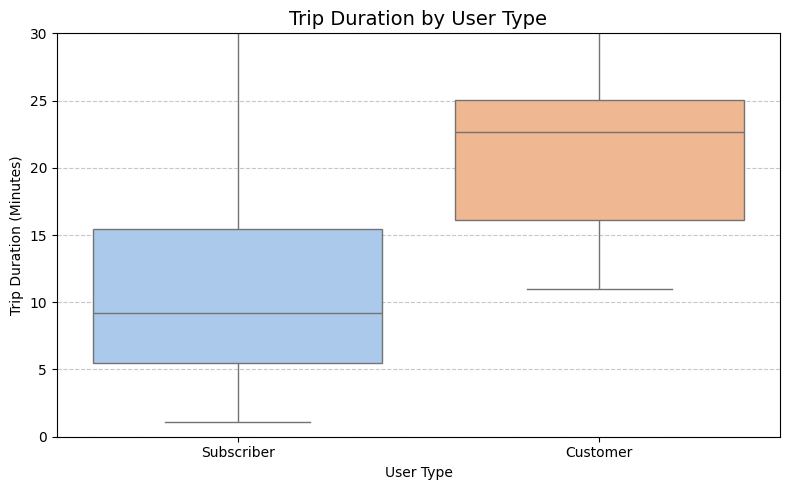

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the original DataFrame 'df' instead of 'df_clean'
df['trip_duration_min'] = df['tripduration'] / 60

# Plot a boxplot with capped y-axis
plt.figure(figsize=(8, 5))
sns.boxplot(x='usertype', y='trip_duration_min', data=df, palette='pastel')  # Use 'df' here as well

# Add title and labels
plt.title('Trip Duration by User Type', fontsize=14)
plt.xlabel('User Type')
plt.ylabel('Trip Duration (Minutes)')

# Limit y-axis for clarity
plt.ylim(0, 30)  # Only show 0–30 min trips visually
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EDA #1 Results

From this box plot, we are able to see how subscribers tend to have shorter rides only averaging around 9 minutes, compared to the Customer's average rides being over double that, around 23 minutes per ride. This can be attributed by the reason each user type ride with CitiBike.

 The subscribers tend to be NYC residents, so they use them in short bursts to either go to work or a set location. They also know they can reserve their bike for later so they have no fear of not having a way to get there. Additionally, because they pay the monthly fee, they are not as concerned with the price per minute of their rides.

 Customers however, use CitiBikes in a completley different way. They use CitiBikes moreso as a way to experience NYC, so they will take much longer rides to simply sightsee and ride around the city for fun. They also are aware that they are being charged a price/minute, but they see it moreso as another experience in a city and accept paying the cost.

 From this, Citi has more control over both consumer types. They are aware that during the early morning, not many of their Customers will be using them for recreational purposes. Citi can then ease the minds of the Subscribers that they have a reliable way of commuting to work, while the Customers can have flexible pricing and availibilty throughout the city.

## Exploratory Analysis #2: Ride Count by Day Chart

In [25]:
import plotly.express as px
import pandas as pd

# Extract hour
df_clean['hour'] = df_clean['starttime'].dt.hour

# Convert to labels like "6 AM", "12 PM"
hour_labels = {h: f"{h % 12 or 12} {'AM' if h < 12 else 'PM'}" for h in range(24)}
df_hourly = df_clean.groupby('hour').size().reset_index(name='ride_count')
df_hourly['hour_label'] = df_hourly['hour'].map(hour_labels)

# Sort by hour to keep correct time order
df_hourly = df_hourly.sort_values('hour')

# Plot with labels
fig = px.line(df_hourly, x='hour_label', y='ride_count', markers=True,
              title='Ride Count by Time of Day')
fig.update_layout(xaxis_title='Time of Day', yaxis_title='Number of Rides')
fig.show()



## EDA #2 Results

This diagram shows the number of rides (Y Axis) compared to the hours of the day (X Axis). This diagram displays how the 2 most active times for CitiBike users are the hours of 7am to 10am, as well as 1pm to 4pm, steadily decreasing as it gets later into the night. This shows how both consumer types are active at these times. Subscribers are the ones heading to work from 7-10, using their memberships to ensure their bike. And most tourists don't start exploring the city until around 12pm, where the average number of rides increases to almost 80. 4pm has the largest peak of riders of almost 100 active riders, as it is when both the Subscribers are returning home from work, as well as many Customers also riding at the same time.

This business model has been tested and calculated to maximize their profits for both customer bases. They get their regular riders every morning with their subscription model, knowing that they need their service to get to work. And for the rest of the day, they can change their rates depending on events in the city.

## Subscriber vs Customer Logistic Regression Model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Step 1: Prep the dataset
df_model = df_clean.copy()

# Feature engineering
df_model['hour'] = df_model['starttime'].dt.hour
df_model['dayofweek'] = df_model['starttime'].dt.dayofweek
df_model['trip_duration_min'] = df_model['tripduration'] / 60

# Drop missing and unknown gender
df_model = df_model.dropna(subset=['birth_year', 'gender', 'usertype'])
df_model = df_model[df_model['gender'] != 0]

# Encode usertype (target)
le = LabelEncoder()
df_model['usertype_encoded'] = le.fit_transform(df_model['usertype'])  # Customer = 0, Subscriber = 1

# Define features
features_numerical = ['trip_duration_min', 'hour', 'dayofweek', 'birth_year']
features_categorical = ['gender']
X = df_model[features_numerical + features_categorical]
y = df_model['usertype_encoded']

# Preprocessing: OneHot for categorical, passthrough numerical
preprocessor = ColumnTransformer([
    ('num', 'passthrough', features_numerical),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), features_categorical)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Train logistic regression with class weighting
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_transformed, y_train)

# Predict
y_pred = model.predict(X_test_transformed)

# Evaluate
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    Customer       0.09      1.00      0.17         6
  Subscriber       1.00      0.80      0.89       294

    accuracy                           0.81       300
   macro avg       0.55      0.90      0.53       300
weighted avg       0.98      0.81      0.88       300



## Logistic Regression Analysis

This Logistic Regression Model was created to predict whether a rider was a Subscriber or a Customer based on the data set, such as the time they rode, age, gender, and how long/far their ride was. From the results, this model is very good at predicting who a subscriber is, and slightly worse at predicting potential customers. This is because a regular customer can be ANY person in NYC, with all varying ages and ride lengths. It is effective to have a high accuracy for subscribers, because they are the ones who have routines using CitiBikes, allowing Citi to learn more about them.

## Conclusion

From the data shown, CitiBike has a very good balance in both Subscribers and Cusomers happy. Since most Subscribers are NYC residents, it gives them a fun and reliable way to travel to work or around the city themselves. And for Customers, a unique way to sightsee NYC, get exercise, or just have fun exploring. This data can be used by Citi to both learn more about their own consumer base, as well as making changes to pricing as well as allocation of bikes, to optimize both consumer bases to have even more people using their service.